In [10]:
# 데이터의 차원 축소

import pandas as pd
import numpy as np 
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from PIL import Image
import seaborn as sns
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 50)


In [11]:
df = pd.read_csv('./result_data/data.csv')

t_df = df.drop(columns=["timestamp", "price", "Unnamed: 0"], axis=1)
t_df = t_df.abs()

for i in range(1, 11, 1):
    for j in range(i - 1, 0, -1):
        t_df[f'ask{i}'] += df[f'ask{j}']
        t_df[f'bid{i}'] += df[f'bid{j}']

In [12]:
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(t_df.values)
inertia = kmeans.inertia_ 
labels = kmeans.labels_
df['kmeans_raw_data_label'] = labels
df = df[['timestamp', 'price', 'kmeans_raw_data_label']]


df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
df.rename(columns={"label": "kmeans_raw_data_label"}, inplace=True)
df = df[df['datetime'] > "2023-12-01"]

In [13]:
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['target'] = np.where(df['price'].shift(-1) > df['price'], 1, 0)

In [23]:
df.to_csv("./result_data/kmeans_raw.csv")

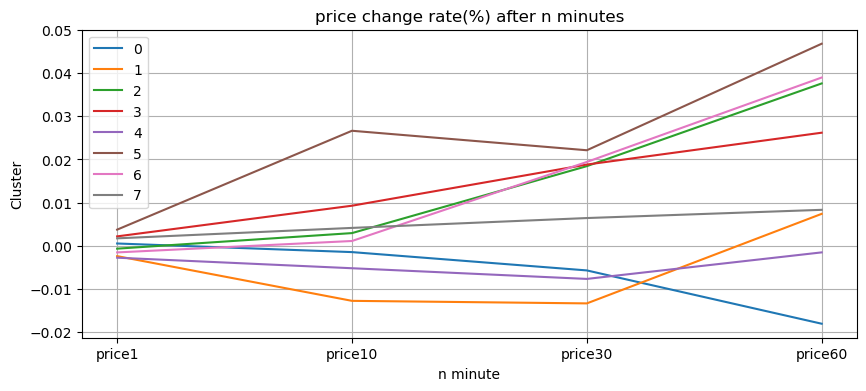

In [22]:
tt_df = df.iloc[0:90000]

tt_df['price1'] = (tt_df['price'].shift(-1) / tt_df['price'] - 1) * 100
tt_df['price10'] = (tt_df['price'].shift(-10) / tt_df['price'] - 1) * 100
tt_df['price30'] = (tt_df['price'].shift(-30) / tt_df['price'] - 1) * 100 
tt_df['price60'] = (tt_df['price'].shift(-60) / tt_df['price'] - 1) * 100

tt_df.dropna(inplace=True)

grouped = tt_df.groupby("kmeans_raw_data_label")

result_df = pd.DataFrame(grouped.mean().sort_values(by='kmeans_raw_data_label', ascending=True)['price1'])
result_df['price10'] = grouped.mean().sort_values(by='kmeans_raw_data_label', ascending=True)['price10']
result_df['price30'] = grouped.mean().sort_values(by='kmeans_raw_data_label', ascending=True)['price30']
result_df['price60'] = grouped.mean().sort_values(by='kmeans_raw_data_label', ascending=True)['price60']
result_df2 = result_df.transpose()


plt.figure(figsize=(10, 4))
plt.plot(result_df2.index, result_df2[0], label="0")
plt.plot(result_df2.index, result_df2[1], label="1")
plt.plot(result_df2.index, result_df2[2],  label="2")
plt.plot(result_df2.index, result_df2[3], label="3")
plt.plot(result_df2.index, result_df2[4], label="4")
plt.plot(result_df2.index, result_df2[5], label="5")
plt.plot(result_df2.index, result_df2[6], label="6")
plt.plot(result_df2.index, result_df2[7], label="7")


plt.ylabel('Cluster')
plt.xlabel('n minute')

plt.title('price change rate(%) after n minutes')
plt.grid()
plt.legend(loc='upper left')
plt.show()